# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения, c различными гиперпараметрами (коэффициент обучения и betas)
    * SGD, SGD+momentum, Adam
    
За все три задания 1 бал, срок выполнения 2 недели, после 0.5 бала.

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку pytorch. Получаем на вход тензор размером $(B, C_{in}, H, W)$, на выходе получаем тензор $(B, C_{out}, H_{out}, W_{out})$.
$$
B \ - \ размерность\ батча. \\
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки:
$$
\begin{equation*}
\text{out}(B_i, C_{out_j}) = \text{bias}(C_{out_j}) +
                        \sum_{k = 0}^{C_{in} - 1} \text{kernel}(C_{out_j}, k) \star \text{x}(B_i, k)
\end{equation*},
$$

где $\large k $ - ядро свертки, с парамерами $C_{in}, H_k, W_k, stride_{H,W}, padding_{H,W}  $.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [15]:
# прототип функции 
def my_conv2d(X,
              kernel,
              stride=(1,1), pad=(0,0), bias=None):
    """
    Arguments:
    :param  X: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда
    :param  padding:  tuple - параметры паддинга
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    C, H, W = X.size()
    C_k, kernelSizeH, kernelSizeW = kernel.size()
    
    if (C_k == 1):
        newKernel = torch.zeros(C, kernelSizeH, kernelSizeW)
        for c in range(C):
            newKernel[c, :, :] = kernel
        kernel = newKernel
    
    HH = ((H + 2 * pad[0] - kernelSizeH) / stride[0]) + 1
    WW = ((W + 2 * pad[1] - kernelSizeW) / stride[1]) + 1
    if (not HH.is_integer() or not WW.is_integer()):
        print("Conv doesnt fit!")
        return None
    else:
        HH = int(HH)
        WW = int(WW)
        out = torch.zeros(HH, WW)
        XX = torch.zeros((C, H + 2 * pad[0], W + 2 *pad[1]))
        XX[:, pad[0] : H + pad[0], pad[1] : W + pad[1]] = X
        

    for h_i, h_s in enumerate(range(0, H + 2 * pad[0] - kernelSizeH + 1, stride[0])):
        for w_i, w_s in enumerate(range(0, W + 2 * pad[1] - kernelSizeW + 1, stride[1])):
            for c in range(C):
                out[h_i, w_i] += torch.sum((XX[c, h_s : h_s + kernelSizeH, w_s : w_s + kernelSizeW] * kernel[c, :, :]))          
    return out

## Тестируем функцию свертки

### Загружаем картинку 

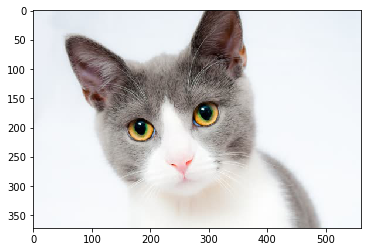

In [16]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [17]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [18]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([370, 558])


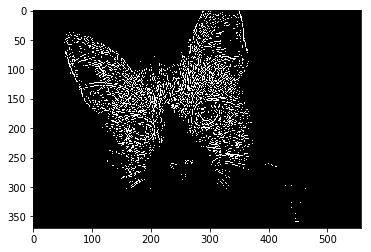

In [19]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [20]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


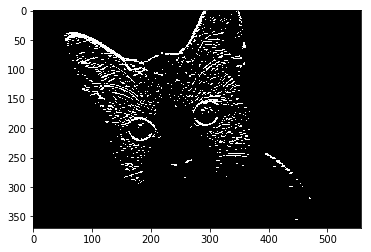

In [21]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')
print(o_image)

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [22]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


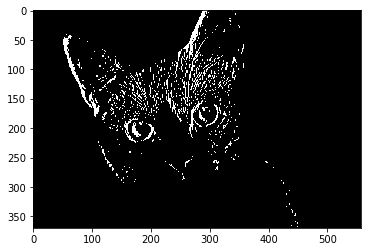

In [23]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])


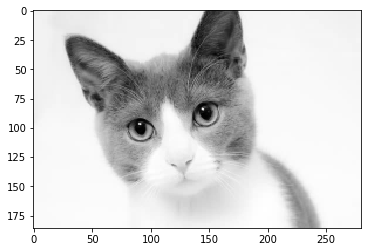

In [24]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Ядро свертки с гаусовым распределением

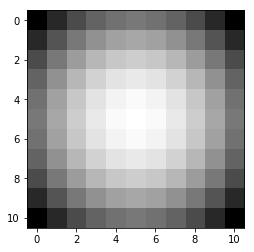

In [25]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])


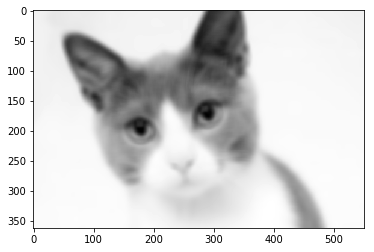

In [26]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

# 2. Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \gamma, b $ - параметры расчитанные в процессе тренировки слоя.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй

Нужные функции
```python
import torch
torch.zeros #- создать тензор заполненный нулями
torch.ones #- создать тензор заполненный единицами
torch.Tensor #- создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  #- среднее и дисперсия
x.uniform_ #- заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) #- разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1 
```

In [27]:
import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        self.inChannels = in_channels
        self.isAffine = afine
        self.momentum = beta
        self.eps = epsilon
        
        self.params = []
        
        for c in range(in_channels):
            self.params.append({"gamma" : 1,
                               "bias" : 0, 
                               "runningMean" : 0,
                               "runningVar" : 0})
        
        pass
        
    def forward(self, X):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        """

        N, C, h, w = X.size()
        if (C != self.inChannels):
            raise ValueError('Invalid forward to batchnorm')
            
        out = torch.zeros(X.size())  
    
                
        if self.training:
            momentum = self.momentum
            for c in range(C):
                gamma = self.params[c]["gamma"]
                bias = self.params[c]["bias"]
                
                localX = X[:, c, :, :]
                
                sampleMean = localX.mean()
                sampleVar = localX.var()

                intermediateOut = (localX - sampleMean) / np.sqrt(sampleVar + self.eps)
    
                if self.isAffine:
                    out[:, c, :, :] = gamma * intermediateOut + bias
                else:
                    out[:, c, :, :] = intermediateOut

                self.params[c]["runningMean"] = momentum * self.params[c]["runningMean"] + (1 - momentum) * sampleMean
                self.params[c]["runningVar"] = momentum * self.params[c]["runningVar"] + (1 - momentum) * sampleVar

        else:
            for c in range(C):
                gamma = self.params[c]["gamma"]
                bias = self.params[c]["bias"]
                localX = X[:, c, :, :]
                intermediateOut = (localX - self.params[c]["runningMean"]) / np.sqrt(self.params[c]["runningVar"] + self.eps)
                if self.isAffine:
                    out[:, c, :, :] = gamma * intermediateOut + bias
                else:
                    out[:, c, :, :] = intermediateOut
            
        return out
           


### Проверяем работу батч нормадлизации на котэ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 372, 560])


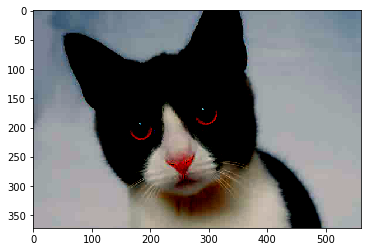

In [28]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))


# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 372, 560])


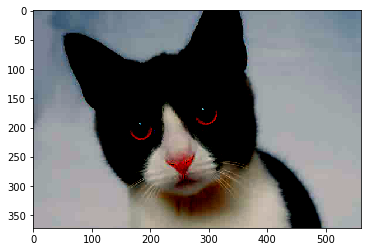

In [29]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, afine=True)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

### Проверим как реализация работает на большом сете картинок

In [30]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [31]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


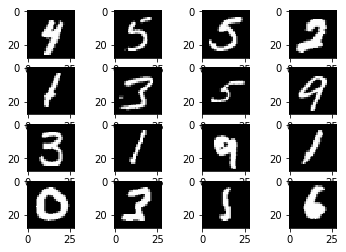

In [32]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [33]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.params[0]["runningMean"]]  # Zero because we have only one Layer of filtres 
            var_curve +=  [ bn.params[0]["runningVar"]]
    return mean_curve, var_curve

In [34]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

Смотрим какие значения средних и дисперсий у нас получились

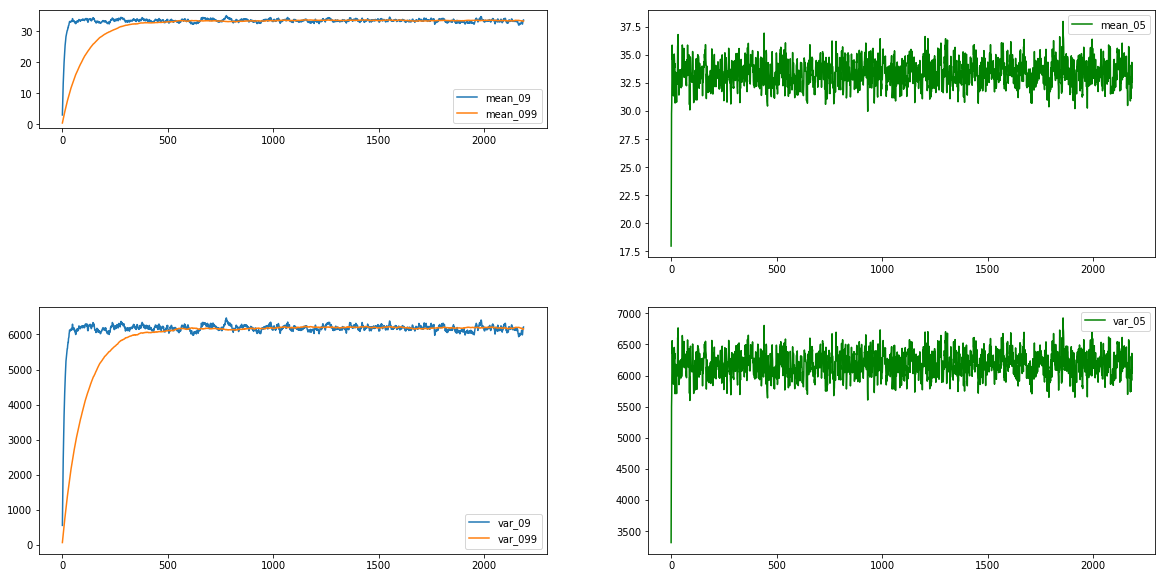

In [35]:
plt.figure(figsize=(20,10))
ax = plt.subplot(4,2,1)
ax.plot(mean_curve_09,label="mean_09")
ax.plot(mean_curve_099,label="mean_099")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05,label="mean_05",  color='g')
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(var_curve_09,label="var_09",)
ax.plot(var_curve_099,label="var_099",)
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(var_curve_05,label="var_05",  color='g')
ax.legend()

Посмотрим как повлияла батч нормализация на изображения

784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])
784
torch.Size([1, 1, 28, 28])


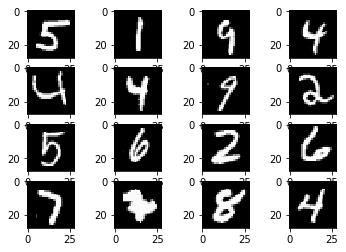

In [36]:
n=4
bn = bn_09
bn.train(False)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    print(I.size)
    x = torch.Tensor(I)
    print(x.unsqueeze(0).unsqueeze(0).size())
    I = bn(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze()
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), сделать выводы


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \times \ m_{t-1} + (1 - \alpha)\times g - момент \\ 
v_t &= \beta \times v_{t-1} +  (1-\beta)\times g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\times \hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^2}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$

Полезные функции

```python
import torch
torch.zeros_like(x)  # сделать тензор нулей такойже как x
tensor.addcmul_, addcdiv_, mul_  # все функции операции с тензорами, которые заканчиваются на _ присваивают результат в self тензор 
```


In [59]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] # betas
            eps = group['eps'] # эпсилон
            lr = group['lr'] # коэффициент обучения
            
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                    
                # забираем тензор градиента    
                grad = p.grad.data
                # сами параметры для обновления лежат тут
                # p.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['avg'] = torch.zeros_like(p.data) # нужно проинициализировать TODO
                    # скользящее среднее по квадрату градиентов
                    state['avg_sq'] = torch.zeros_like(p.data)# нужно проинициализировать TODO

                # тут можем достать сохраненные состояния
                exp_avg, exp_avg_sq = state['avg'], state['avg_sq']
                        
                # запоминаем шаг 
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                t = state['step'] + 1
                momentum = beta1 * exp_avg + (1 - beta1) * p.grad.data
                momentumNorm = momentum / (1 - beta1**t)
                adaGrad = beta2 * exp_avg_sq + (1 - beta2) * (p.grad.data**2)
                adaGradNorm = adaGrad / (1 - beta2**t)
                # обновляем веса в p.data, 
                p.data = p.data - lr * momentumNorm  / (np.sqrt(adaGradNorm) + eps)
                
                state['avg'], state['avg_sq'] = momentum, adaGrad

        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta \times m_{t-1} - (1- \beta) \times g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha \times m_{t-1} - \lambda \times g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [45]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания, если 0, получаем обычный SGD
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                
                if p.grad is None:
                    continue
                # gradient                                
                grad = p.grad.data
                
                state = self.state[p]
                
                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['mom'] = torch.zeros_like(p.data)
                    
                momentum = state['mom']
                
                if beta != 0:
                    momentum = beta * momentum + (1 - beta) * grad
                    p.data = p.data - lr * momentum 
                else:
                    p.data = p.data - lr * grad
                
               

        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [46]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [47]:
USE_CUDA=False

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
            

        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            

        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

## Функция обучения модели

In [49]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward() # <-- тут расчитывается градиент
            optimizer.step()  # <-- тут происходит обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [50]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd = fit_net(20, net, optimizer) # обучаем сеть

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.11548794292605082
Do epoch 1 with loss 0.0515604632960698
Do epoch 2 with loss 0.04032432504941952
Do epoch 3 with loss 0.03289267342072619
Do epoch 4 with loss 0.02961461568633661
Do epoch 5 with loss 0.02554141349875878
Do epoch 6 with loss 0.021678920162421796
Do epoch 7 with loss 0.020626345663840334
Do epoch 8 with loss 0.018459194808666927
Do epoch 9 with loss 0.015695751343598692
Do epoch 10 with loss 0.01491761760156777
Do epoch 11 with loss 0.014412347750272388
Do epoch 12 with loss 0.01265181004183446
Do epoch 13 with loss 0.010530376644182488
Do epoch 14 with loss 0.010347962297693365
Do epoch 15 with loss 0.009967458826606003
Do epoch 16 with loss 0.008736305119351378
Do epoch 17 with loss 0.008477221654875397
Do epoch 18 with loss 0.00697257003189496
Do epoch 19 with loss 0.006758410873672544


## SGD с моментом

In [51]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.270754675462222
Do epoch 1 with loss 0.07131431372533882
Do epoch 2 with loss 0.053185641002480605
Do epoch 3 with loss 0.043567585632388973
Do epoch 4 with loss 0.03773581391608383
Do epoch 5 with loss 0.03300868532785172
Do epoch 6 with loss 0.029727664868554732
Do epoch 7 with loss 0.027109902987455088
Do epoch 8 with loss 0.0240036409925695
Do epoch 9 with loss 0.02300466851905758
Do epoch 10 with loss 0.020942851410481175
Do epoch 11 with loss 0.019982793844067783
Do epoch 12 with loss 0.018014111251633734
Do epoch 13 with loss 0.01714582251709348
Do epoch 14 with loss 0.016090742548715595
Do epoch 15 with loss 0.014491169241175675
Do epoch 16 with loss 0.013908243793900503
Do epoch 17 with loss 0.01323556975995126
Do epoch 18 with loss 0.012728807584957058
Do epoch 19 with loss 0.011886607731211715


## Adam

In [60]:
learning_rate = 1e-4
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.5809233663394999
Do epoch 1 with loss 0.14202756958297796
Do epoch 2 with loss 0.09260270813719344
Do epoch 3 with loss 0.07070233697385946
Do epoch 4 with loss 0.058669924167094295
Do epoch 5 with loss 0.050360445384571524
Do epoch 6 with loss 0.044464686692142576
Do epoch 7 with loss 0.04001892312414089
Do epoch 8 with loss 0.03611621172407963
Do epoch 9 with loss 0.03355296107735545
Do epoch 10 with loss 0.03097601804182199
Do epoch 11 with loss 0.028793582295003305
Do epoch 12 with loss 0.02669185774752578
Do epoch 13 with loss 0.025129717110797156
Do epoch 14 with loss 0.02375047006629404
Do epoch 15 with loss 0.02259321356124948
Do epoch 16 with loss 0.02122321287974899
Do epoch 17 with loss 0.020063216450092288
Do epoch 18 with loss 0.019150028496667245
Do epoch 19 with loss 0.018300594773039625


# Кривые обучения

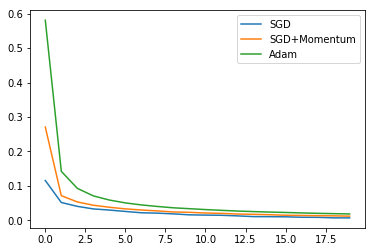

In [61]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы

_пишем выводы по сходимости и скорости обучения: Adam, SGD, SGD+momentum, с различными параметрами обучения lr и betas_

Мы наблюдаем крайне странную ситацию, где обычный SGD обогнал adam. 
Почти наверное это произошло из-за тривиальности датасета, ведь даже простые двухслойные FC слои выбивают на нём accuracy под 98%.
Я имел опыт реализации и тестирования adam на более сложном датасете - CIFAR10, там adam показывает значительно лучший результат.